In [0]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

from numpy import genfromtxt

# ЭТАП ПОДГОТОВКИ ДАННЫХ

# получаем метки для обучающего множества
Y_train = genfromtxt('train_sequence.csv', delimiter=',')

# Описываем метод для обработки видеопотока
def processing_for_flv_file(video_read):
  # получаем количество кадров в секунду
  fps = video_read.get(cv2.CAP_PROP_FPS)
  # получаем размер кадра
  size = (int(video_read.get(cv2.CAP_PROP_FRAME_WIDTH)), int(video_read.get(cv2.CAP_PROP_FRAME_HEIGHT)))

  # получаем общее колчество кадров
  totalFrames = video_read.get(cv2.CAP_PROP_FRAME_COUNT)

  # создаем нулевую матрицу
  matrix = np.zeros([int(totalFrames), size[0], size[1]])

  # сохраняем каждый кадр ввиде матрицы
  for i in range(int(totalFrames)):
      ret, frame = video_read.read()
      matrix[i] = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
      # plt.imshow(x_train[i])
      # plt.show()
      # cv2.imshow("Video", frame)
      if cv2.waitKey(20) & 0xFF == ord('q'):
          break

  return matrix

# Create an object of VideoCapture class to read video file
train_video = cv2.VideoCapture("train.flv")
X_train = processing_for_flv_file(train_video)

test_video = cv2.VideoCapture("test.flv")
X_test = processing_for_flv_file(test_video)

In [152]:
# ПРОВЕРИМ РАЗМЕР ВЫХОДНЫХ ДАННЫХ
print('X_train size: {}'.format(X_train.shape))
print('X_test size: {}'.format(X_test.shape))
print('Y_train size: {}'.format(Y_train.shape))

X_train size: (42000, 56, 56)
X_test size: (5000, 56, 56)
Y_train size: (42000,)


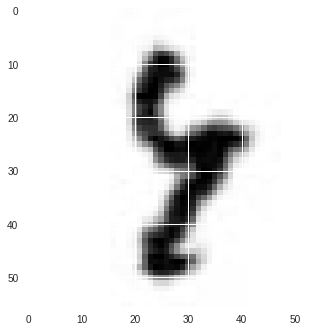

label 4.0


In [154]:
# Визуализация полученных данных для обучения
index = np.random.randint(X_train.shape[0])
plt.imshow(X_train[index])
plt.show()

print('label {}'.format(y_train[index]))

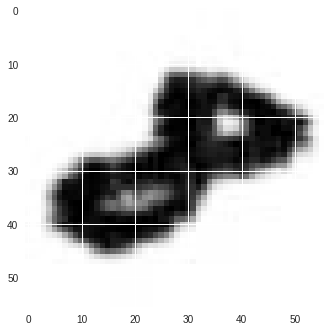

In [156]:
# Визуализация полученных данных для тестирования
index = np.random.randint(X_test.shape[0])
plt.imshow(X_test[index])
plt.show()

In [0]:
# сохряняем полученные данные в удобном для нас формате 
# для воспоризводимости результатов
np.save('X_train_mnist', X_train)
np.save('y_train_mnist', Y_train)
np.save('X_test_mnist', X_test)

Пример из обучающей выборки, label 8.0


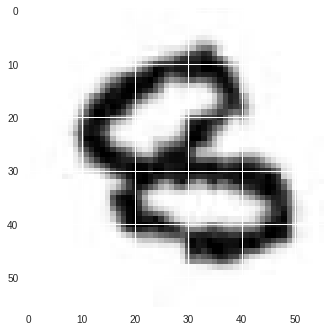

Пример из тествой выборки


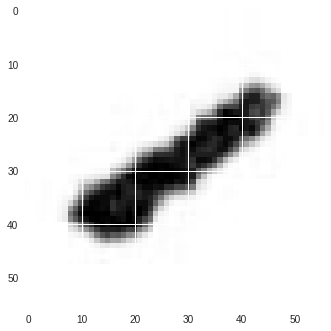

In [160]:
# Если необходимо загрузить данные
X_train = np.load('X_train_mnist.npy')
Y_train = np.load('y_train_mnist.npy')
X_test = np.load('X_test_mnist.npy')


index = np.random.randint(X_train.shape[0])
print('Пример из обучающей выборки, label {}'.format(Y_train[index]))
plt.imshow(X_train[index])
plt.show()

print('Пример из тествой выборки')

index = np.random.randint(X_test.shape[0])
plt.imshow(X_test[index])
plt.show()

In [161]:
# Загружаем необходимые модули 
# Укажем метод оптимизации, а также гипер параметры
# нормируем данные и проведем унитарное кодирование меток

from keras import backend as k
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.optimizers import SGD, RMSprop, Adam
from keras.utils import np_utils


NB_EPOCH = 10
BATCH_SIZE = 128
VERBOSE = 1
NB_CLASES = 10 
OPTIMIZER = Adam(lr=0.001)
VALIDATION_SPLIT = 0.1
IMG_ROWS, IMG_COLS = X_train.shape[1], X_train.shape[2]
INPUT_SHAPE = [1, IMG_ROWS, IMG_COLS]

# указываем, что в кчестве backend будет библиотека theano
k.set_image_dim_ordering("th")

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

# нормировать значение интенсивности пикселя [0, 1]
X_train /= 255
X_test /= 255

# нам нужна форма M * [1*56*56], подаваемая на вход CNN
X_train = X_train[:, np.newaxis, :, :]
X_test = X_test[:, np.newaxis, :, :]
print(X_train.shape, 'X_train.shape')
print(X_train.shape[0], 'train_samples')
print(X_test.shape[0], 'test_samples')

#  - преобразование векторов классов в бинарные матрицы классов
Y_train = np_utils.to_categorical(y_train, NB_CLASES)


(42000, 1, 56, 56) X_train.shape
42000 train_samples
5000 test_samples


In [0]:
# Строим архитектуру


class Lenet:
    @staticmethod
    def build(input_shape, classes):
        model = Sequential()
        # CONV => CONV => RELU => POOL
        model.add(Conv2D(20, kernel_size=3, padding='same', input_shape=input_shape, activation='relu'))
        model.add(Conv2D(30, kernel_size=3, padding='same', input_shape=input_shape, activation='relu'))
        model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
        # CONV => CONV => RELU => POOL
        model.add(Conv2D(50, kernel_size=3, padding='same', input_shape=input_shape, activation='relu'))
        model.add(Conv2D(60, kernel_size=3, padding='same', input_shape=input_shape, activation='relu'))
        model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
        # слои Flatten => RELU
        # Flatten - слой уплотнения (то есть мы берем и вытягиваем получившиеся признаки в вектор
        # строку размрености (50*14*14, ))
        model.add(Flatten())
        #  и плотный слой с 500 нейронами
        model.add(Dense(500, activation='relu'))
        # softmax -классификатор   
        model.add(Dense(classes, activation='softmax'))
        model.summary()
        return model

In [163]:
# инициализируем оптимизатор и модель
model = Lenet.build(input_shape=INPUT_SHAPE, classes=NB_CLASES)

# определеяем метод оптимизации и функцию потерь.
model.compile(loss='categorical_crossentropy', optimizer=OPTIMIZER, metrics=['accuracy'])
# обучение модели
history = model.fit(X_train, Y_train, batch_size=BATCH_SIZE, epochs=NB_EPOCH,
                    verbose=VERBOSE, validation_split=VALIDATION_SPLIT)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_18 (Conv2D)           (None, 20, 56, 56)        200       
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 30, 56, 56)        5430      
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 30, 28, 28)        0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 50, 28, 28)        13550     
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 60, 28, 28)        27060     
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 60, 14, 14)        0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 11760)             0         
__________

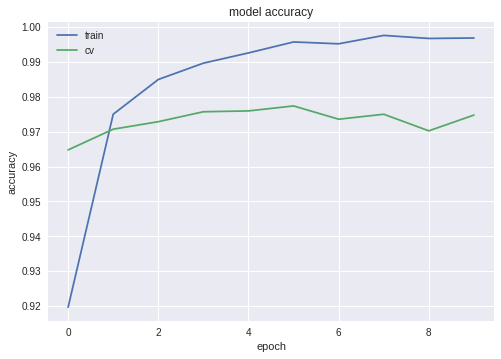

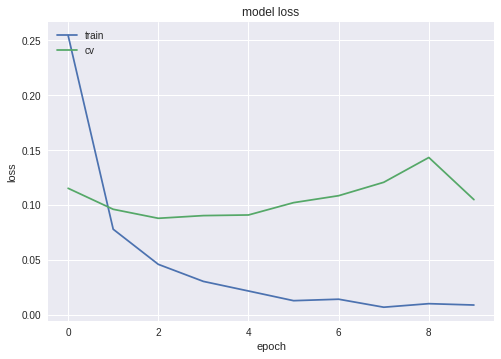

In [164]:
# построить график изменения доли правильных ответов
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'cv'], loc='upper left')
plt.show()

# построить график изменения функции потерь
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'cv'], loc='upper left')
plt.show()


In [0]:
# предскажем метки классов на тестовом множестве
Y_test = model.predict_classes(X_test)

Предсказана метка 9


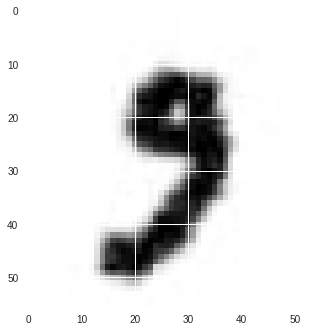

In [171]:
# сопоставим предсказанную метку и пример из тестового множества
index = np.random.randint(X_test.shape[0])
print('Предсказана метка {}'.format(Y_test[index]))
plt.imshow(X_test.reshape([X_test.shape[0], X_test.shape[2],X_test.shape[3]])[index])
plt.show()


In [0]:
# сохраняем предсказанные метки для тестового множества в csv-файл
np.savetxt('test_sequence.csv', Y_test, fmt='%.0f') 
# для чтения из файла: 
# Y_test = np.loadtxt('test_sequence.csv')

In [0]:
# сохраним архитектуру CNN, веса и откомпелированную модель
model.save('CNN_mnist_all_model.h5')

In [177]:
# проверяем, что все верно сохранилось
from keras.models import load_model

model_load = load_model('CNN_mnist_all_model.h5')
score = model_load.evaluate(X_train, Y_train, verbose=VERBOSE)
print("TRAIN cost_function:", score[0])
print("TRAIN accuracy:", score[1])

42000/42000 [==============================] - 11s 256us/step
TRAIN cost_function: 0.02024459530014567
TRAIN accuracy: 0.9940714285714286
